## 1.YOLO model load

In [4]:
from ultralytics import YOLO
import os, random, cv2
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from sklearn.model_selection import ParameterGrid

In [5]:
model = YOLO("runs/ua_detrac_yolo/weights/best.pt")

# View model structure
model.info()

Model summary: 129 layers, 3,011,628 parameters, 0 gradients, 8.2 GFLOPs


(129, 3011628, 0, 8.197376)

In [6]:
metrics = model.val(data="data.yaml", split="val", imgsz=640, conf=0.25)
print(metrics.box.map)      # mAP@0.5
print(metrics.box.map50)    # mAP@0.5
print(metrics.box.map75)    # mAP@0.75
print(metrics.box.maps)     # mAP for each category

Ultralytics 8.3.95  Python-3.11.4 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\Northeastern\6220\project\labels\test.cache... 56167 images, 173 backgrounds, 0 corrupt: 100%|████████
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3522/3522 [1


                   all      56340     675774      0.624      0.647      0.668      0.538
                   car      55764     548555      0.688      0.776      0.791      0.623
                   bus      30922      71785      0.701      0.821       0.82      0.669
                   van      23508      38519      0.593      0.583      0.641       0.53
                others      15957      16915      0.515      0.408       0.42      0.331
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\val
0.5382244481589515
0.6679371682990556
0.6291842472045973
[    0.62284     0.66884     0.53006     0.33116]


### YOLOv8 Model Evaluation on UA-DETRAC (Validation Set)

We evaluated our trained YOLOv8 model using the validation split defined in `data.yaml`. Below are the key results:

#### Overall Detection Metrics

| Metric            | Value   | Description                                   |
|-------------------|---------|-----------------------------------------------|
| **mAP@0.5:0.95**  | 0.538   | Mean Average Precision across IoU thresholds from 0.5 to 0.95 (step 0.05) |
| **mAP@0.5**       | 0.668   | Precision averaged at IoU threshold = 0.5     |
| **mAP@0.75**      | 0.629   | Precision averaged at IoU threshold = 0.75     |

#### Per-Class Metrics

| Class     | Precision | Recall | mAP@0.5 | mAP@0.5:0.95 |
|-----------|-----------|--------|---------|---------------|
| **car**   | 0.688     | 0.776  | 0.791   | 0.623         |
| **bus**   | 0.701     | 0.821  | 0.820   | 0.669         |
| **van**   | 0.593     | 0.583  | 0.641   | 0.530         |
| **others**| 0.515     | 0.408  | 0.420   | 0.331         |

- **Observation**: Detection performance is best for large and distinct vehicles like **cars** and **buses**.
- The model performs slightly worse on **vans** and **others**, likely due to smaller object size or visual ambiguity.

### Inference Speed

- **Preprocess**: 0.2 ms/image  
- **Inference**: 3.5 ms/image  
- **Postprocess**: 1.7 ms/image  
- Inference is efficient and suitable for near real-time applications.

## 1.1 Grid Search on YOLO

- To optimize our YOLOv8 model's performance on the UA-DETRAC dataset, we implemented a **custom Grid Search strategy**.
- The goal is to identify the best combination of training hyperparameters that enhance detection accuracy while maintaining training stability.

---

#### Grid Search Setup
- We defined **8 unique parameter combinations**, varying:
  - **Initial learning rate (`lr0`)**
  - **Optimizer type (`Adam` or `SGD`)**
  - **Momentum**
  - **Weight decay**

#### Training Procedure Per Grid
For **each parameter set**, we performed the following four steps:

1. **Random Sampling**  
   - From the full training set (`images/train`), we randomly sample **5000 images** and their corresponding label files.
   - This ensures consistent and fair evaluation of each hyperparameter setting while significantly reducing training cost.

2. **Training**  
   - Fine-tune the base model (`best.pt`) using the sampled subset for **5 epochs**.
   - Training is conducted with the specified hyperparameters including learning rate, optimizer type, momentum, and weight decay.

3. **Validation**  
   - After training, the model is validated on the **full validation set**.
   - We extract and store the following performance metrics:
     - **mAP@0.5**
     - **mAP@0.5:0.95**
     - **Precision**
     - **Recall**
     - **F1 Score** (calculated from precision and recall)

4. **Loss Tracking**  
   - We parse the YOLO training log (`results.csv`) to extract the **box loss curve**.
   - This helps analyze convergence behavior and training stability for each hyperparameter set.

In [7]:
param_grid = [
    {'lr0': 0.001, 'optimizer': 'Adam', 'momentum': 0.9,  'weight_decay': 0.0005},
    {'lr0': 0.003, 'optimizer': 'Adam', 'momentum': 0.937, 'weight_decay': 0.0005},
    {'lr0': 0.005, 'optimizer': 'Adam', 'momentum': 0.9,  'weight_decay': 0.001},

    {'lr0': 0.001, 'optimizer': 'SGD', 'momentum': 0.9,   'weight_decay': 0.0005},
    {'lr0': 0.005, 'optimizer': 'SGD', 'momentum': 0.937, 'weight_decay': 0.001},
    {'lr0': 0.01,  'optimizer': 'SGD', 'momentum': 0.9,   'weight_decay': 0.0001},

    {'lr0': 0.001, 'optimizer': 'Adam', 'momentum': 0.937, 'weight_decay': 0.001},
    {'lr0': 0.005, 'optimizer': 'Adam', 'momentum': 0.937, 'weight_decay': 0.002},
]

In [14]:
sampled_yaml_content = """
train: ./images/train_sampled
val: ./images/test

nc: 4
names: ['car', 'bus', 'van', 'others']
"""

with open("data_sampled.yaml", "w") as f:
    f.write(sampled_yaml_content.strip())

In [9]:
train_images_dir = "images/train"
train_labels_dir = "labels/train"
sampled_images_dir = "images/train_sampled"
sampled_labels_dir = "labels/train_sampled"
sampled_yaml = "data_sampled.yaml"

In [10]:
# Create sampled folders if needed
os.makedirs(sampled_images_dir, exist_ok=True)
os.makedirs(sampled_labels_dir, exist_ok=True)
all_results = []
loss_curves = {}

In [12]:
def run_grid_search(param_grid, train_images_dir, train_labels_dir,
                    sampled_images_dir, sampled_labels_dir, sampled_yaml):
    os.makedirs(sampled_images_dir, exist_ok=True)
    os.makedirs(sampled_labels_dir, exist_ok=True)

    all_results = []
    loss_curves = {}

    for i, params in enumerate(tqdm(param_grid, desc="Grid Search")):
        print(f"\n Grid {i+1}/{len(param_grid)}: {params}")

        stage_bar = tqdm(total=4, desc=f"Stage [grid{i+1}]", leave=False)

        # Step 1: Sample data
        all_imgs = sorted([f for f in os.listdir(train_images_dir) if f.endswith(".jpg")])
        sampled_imgs = random.sample(all_imgs, 5000)
        sampled_txts = [img.replace(".jpg", ".txt") for img in sampled_imgs]

        for f in os.listdir(sampled_images_dir):
            os.remove(os.path.join(sampled_images_dir, f))
        for f in os.listdir(sampled_labels_dir):
            os.remove(os.path.join(sampled_labels_dir, f))
        for img, label in zip(sampled_imgs, sampled_txts):
            shutil.copyfile(os.path.join(train_images_dir, img), os.path.join(sampled_images_dir, img))
            src_lbl = os.path.join(train_labels_dir, label)
            dst_lbl = os.path.join(sampled_labels_dir, label)
            if os.path.exists(src_lbl):
                shutil.copyfile(src_lbl, dst_lbl)
        stage_bar.update(1)

        # Step 2: Train
        run_name = f"grid{i+1}"
        model = YOLO("runs/ua_detrac_yolo/weights/best.pt")
        model.train(
            data=sampled_yaml,
            epochs=5,
            imgsz=640,
            batch=16,
            name=run_name,
            lr0=params['lr0'],
            optimizer=params['optimizer'],
            momentum=params['momentum'],
            weight_decay=params['weight_decay'],
            verbose=False
        )
        stage_bar.update(1)

        # Step 3: Validate
        val_metrics = model.val()
        f1 = 2 * (val_metrics.box.p * val_metrics.box.r) / (val_metrics.box.p + val_metrics.box.r + 1e-6)
        result = {
            'run': i+1,
            **params,
            'map50': val_metrics.box.map50,
            'map': val_metrics.box.map,
            'precision': val_metrics.box.p,
            'recall': val_metrics.box.r,
            'f1': f1
        }
        all_results.append(result)
        stage_bar.update(1)

        # Step 4: Extract loss curve
        log_path = f"runs/detect/{run_name}/results.csv"
        if os.path.exists(log_path):
            df_log = pd.read_csv(log_path)
            loss_curves[run_name] = df_log['train/box_loss'].tolist()
        stage_bar.update(1)
        stage_bar.close()

    return all_results, loss_curves

In [ ]:
results, losses = run_grid_search(
    param_grid=param_grid,
    train_images_dir="images/train",
    train_labels_dir="labels/train",
    sampled_images_dir="images/train_sampled",
    sampled_labels_dir="labels/train_sampled",
    sampled_yaml="data_sampled.yaml"
)

df = pd.DataFrame(results)
df.to_csv("grid_search_results.csv", index=False)

## 2.Load the results

In [21]:
from ultralytics import YOLO
import os, random, cv2
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from sklearn.model_selection import ParameterGrid

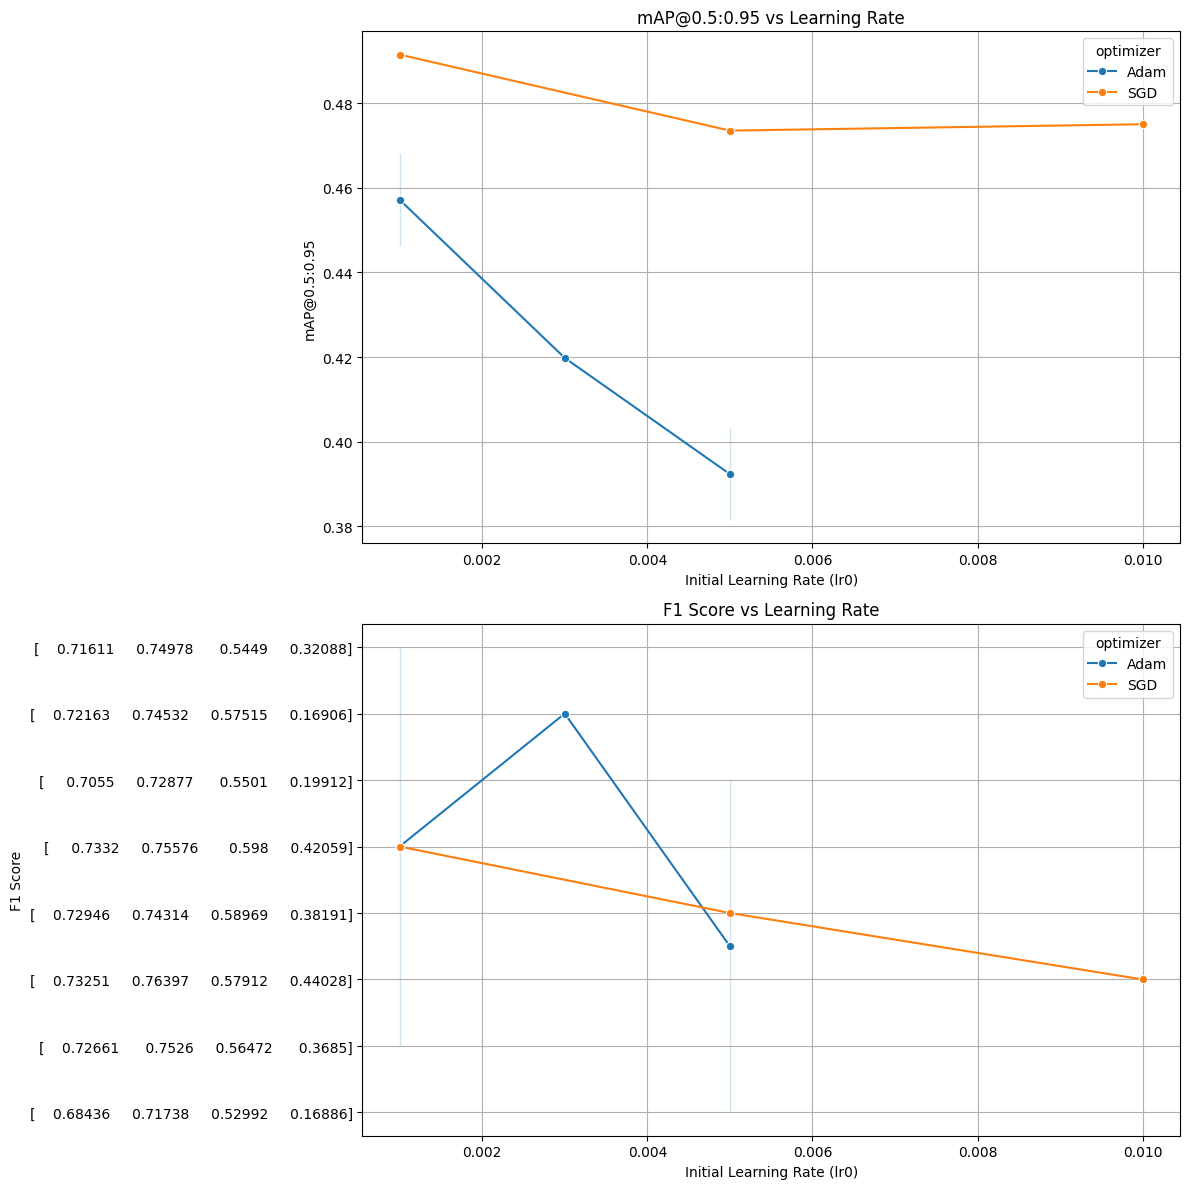

In [27]:
%matplotlib inline
# Load the results
df = pd.read_csv("grid_search_results.csv")

# Create subplots
plt.figure(figsize=(12, 12))

# Plot mAP@0.5:0.95 vs lr0
plt.subplot(2, 1, 1)
sns.lineplot(data=df, x="lr0", y="map", hue="optimizer", marker="o")
plt.title("mAP@0.5:0.95 vs Learning Rate")
plt.xlabel("Initial Learning Rate (lr0)")
plt.ylabel("mAP@0.5:0.95")
plt.grid(True)

# Plot F1 Score vs lr0
plt.subplot(2, 1, 2)
sns.lineplot(data=df, x="lr0", y="f1", hue="optimizer", marker="o")
plt.title("F1 Score vs Learning Rate")
plt.xlabel("Initial Learning Rate (lr0)")
plt.ylabel("F1 Score")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Summary: Best Hyperparameter Candidates

| Goal                          | Best Config                                     |
|-------------------------------|--------------------------------------------------|
| Highest detection accuracy    | `SGD + lr0=0.001` or `SGD + lr0=0.005` (best mAP) |
| Best balance (F1 score)       | `Adam + lr0=0.003`                                |
| Most robust/stable setup      | `SGD + lr0=0.003 ~ 0.005`                         |

## 3.Retrain the YOLO model to use the most optimized hyperparameter configuration `SGD + lr0=0.001`

In [28]:
abs_path = os.getcwd().replace("\\", "/")
data_yaml = f"""
path: {abs_path}
train: images/train
val: images/test

nc: 4
names: ['car', 'bus', 'van', 'others']
"""
with open("data.yaml", "w") as f:
    f.write(data_yaml.strip())

In [ ]:
model = YOLO("yolov8n.pt")

model.train(
    data="data.yaml",
    epochs=30,               
    imgsz=640,
    batch=32,
    workers=8,
    name="final_best_model",            
    lr0=0.001,                   
    optimizer="SGD",             
    momentum=0.9,
    weight_decay=0.0005
)

## 4.Re-predict test video

In [33]:
import os
import cv2
import numpy as np
from glob import glob
from xml.etree import ElementTree as ET
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path  
from ultralytics import YOLO

In [34]:
# ====== configuration ======
IMAGE_DIR = "images/test"
PRED_TXT_DIR = "runs/detect/final_best_model_pred/labels"
ANNOTATION_XML_DIR = "Test-Annotations"
MODEL_PATH = "runs/detect/final_best_model/weights/best.pt"
CONF_THRES = 0.25
IOU_THRES = 0.5

CLASS_NAMES = ['car', 'bus', 'van', 'others']
NUM_CLASSES = len(CLASS_NAMES)

In [35]:
model = YOLO(MODEL_PATH)

results = model.predict(
    source=IMAGE_DIR,
    save=False,
    stream=True,
    conf=CONF_THRES,
    iou=IOU_THRES,
    max_det=100,
    verbose=False,
    name="final_best_model_pred"
)

In [36]:
def parse_ignored_regions(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    regions = []
    ignored_region = root.find("ignored_region")
    if ignored_region is not None:
        for box in ignored_region.findall("box"):
            x = float(box.attrib["left"])
            y = float(box.attrib["top"])
            w = float(box.attrib["width"])
            h = float(box.attrib["height"])
            regions.append((x, y, x + w, y + h))
    return regions

def is_in_ignored_region(cx, cy, ignored_regions):
    for x1, y1, x2, y2 in ignored_regions:
        if x1 <= cx <= x2 and y1 <= cy <= y2:
            return True
    return False

# ====== Filter and save prediction boxes ======
output_dir = Path(PRED_TXT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)
ignored_region_cache = {}

for result in tqdm(results, desc="Re-Predict with Filtering"):
    path = Path(result.path)
    fname = path.stem  # video001_img00042
    video_id = fname.split("_img")[0]

    if video_id not in ignored_region_cache:
        xml_path = os.path.join(ANNOTATION_XML_DIR, video_id + ".xml")
        ignored_region_cache[video_id] = parse_ignored_regions(xml_path)

    ignored_regions = ignored_region_cache[video_id]

    img_h, img_w = result.orig_shape
    filtered_preds = []

    for box in result.boxes.data.cpu().numpy():
        x1, y1, x2, y2, conf, cls_id = box
        cls_id = int(cls_id)
        cx_pixel = (x1 + x2) / 2
        cy_pixel = (y1 + y2) / 2

        if not is_in_ignored_region(cx_pixel, cy_pixel, ignored_regions):
            # Convert to YOLO format (normalized xc, yc, w, h)
            xc = cx_pixel / img_w
            yc = cy_pixel / img_h
            w = (x2 - x1) / img_w
            h = (y2 - y1) / img_h
            filtered_preds.append(f"{cls_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

    # Save as .txt
    save_path = output_dir / f"{fname}.txt"
    with open(save_path, "w") as f:
        f.write("\n".join(filtered_preds))

Re-Predict with Filtering: 56340it [26:21, 35.63it/s]


In [37]:
def evaluate_predictions(pred_dir, gt_dir, xml_dir, image_size=(960, 540), iou_threshold=0.5):
    pred_files = sorted(glob(os.path.join(pred_dir, "*.txt")))
    tp = np.zeros(NUM_CLASSES, dtype=int)
    fp = np.zeros(NUM_CLASSES, dtype=int)
    fn = np.zeros(NUM_CLASSES, dtype=int)
    y_true_all = []
    y_pred_all = []

    for pred_file in tqdm(pred_files, desc="Evaluating"):
        fname = os.path.basename(pred_file)
        video_id = fname.split("_img")[0]

        gt_file = os.path.join(gt_dir, fname)
        if not os.path.exists(gt_file):
            continue

        pred_boxes = np.loadtxt(pred_file).reshape(-1, 5) if os.path.getsize(pred_file) > 0 else np.empty((0, 5))
        gt_boxes = np.loadtxt(gt_file).reshape(-1, 5) if os.path.getsize(gt_file) > 0 else np.empty((0, 5))

        matched_gt = set()

        for pred in pred_boxes:
            pred_cls = int(pred[0])
            pred_box = pred[1:5]
            best_iou = 0
            best_gt_idx = -1
            for i, gt in enumerate(gt_boxes):
                gt_cls = int(gt[0])
                if i in matched_gt or pred_cls != gt_cls:
                    continue
                iou = compute_iou(pred_box, gt[1:5])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = i

            if best_iou >= iou_threshold:
                tp[pred_cls] += 1
                matched_gt.add(best_gt_idx)
                y_true_all.append(pred_cls)
                y_pred_all.append(pred_cls)
            else:
                fp[pred_cls] += 1
                y_pred_all.append(pred_cls)
                y_true_all.append(NUM_CLASSES)  # dummy class

        for i, gt in enumerate(gt_boxes):
            if i not in matched_gt:
                fn[int(gt[0])] += 1

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    print("\nPer-class Metrics:")
    for i, name in enumerate(CLASS_NAMES):
        print(f"{name:8s}  P: {precision[i]:.3f}  R: {recall[i]:.3f}  F1: {f1[i]:.3f}  TP: {tp[i]}  FP: {fp[i]}  FN: {fn[i]}")

    filtered = [(yt, yp) for yt, yp in zip(y_true_all, y_pred_all) if yt < NUM_CLASSES and yp < NUM_CLASSES]
    if filtered:
        y_true, y_pred = zip(*filtered)
        cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
        disp.plot(xticks_rotation=45, cmap='Blues')
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()
    else:
        print("No valid predictions found for confusion matrix.")

    plot_class_metrics(precision, recall, f1, CLASS_NAMES)


In [40]:
# Compute IoU between two boxes (YOLO format)
def compute_iou(box1, box2):
    def to_xyxy(box):
        x, y, w, h = box
        x1 = x - w / 2
        y1 = y - h / 2
        x2 = x + w / 2
        y2 = y + h / 2
        return x1, y1, x2, y2

    x1_1, y1_1, x2_1, y2_1 = to_xyxy(box1)
    x1_2, y1_2, x2_2, y2_2 = to_xyxy(box2)

    inter_x1 = max(x1_1, x1_2)
    inter_y1 = max(y1_1, y1_2)
    inter_x2 = min(x2_1, x2_2)
    inter_y2 = min(y2_1, y2_2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0

In [41]:
def plot_class_metrics(precision, recall, f1, class_names):
    x = np.arange(len(class_names))
    width = 0.25
    plt.figure(figsize=(10, 5))
    bars1 = plt.bar(x - width, precision, width=width, label='Precision')
    bars2 = plt.bar(x, recall, width=width, label='Recall')
    bars3 = plt.bar(x + width, f1, width=width, label='F1-score')

    def annotate_bars(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
                     ha='center', va='bottom', fontsize=9)

    annotate_bars(bars1)
    annotate_bars(bars2)
    annotate_bars(bars3)
    plt.xticks(x, class_names)
    plt.ylim(0, 1.1)
    plt.ylabel("Score")
    plt.title("Per-class Detection Metrics")
    plt.legend()
    plt.tight_layout()
    plt.show()

Evaluating: 100%|███████████████████████████████████████████████████████████████| 56340/56340 [02:23<00:00, 393.30it/s]



Per-class Metrics:
car       P: 0.865  R: 0.770  F1: 0.815  TP: 422344  FP: 66154  FN: 126211
bus       P: 0.904  R: 0.758  F1: 0.825  TP: 54417  FP: 5776  FN: 17368
van       P: 0.668  R: 0.491  F1: 0.566  TP: 18925  FP: 9413  FN: 19594
others    P: 0.664  R: 0.474  F1: 0.554  TP: 8025  FP: 4055  FN: 8890


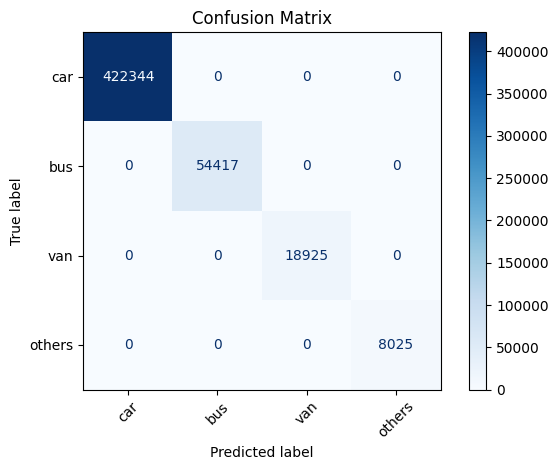

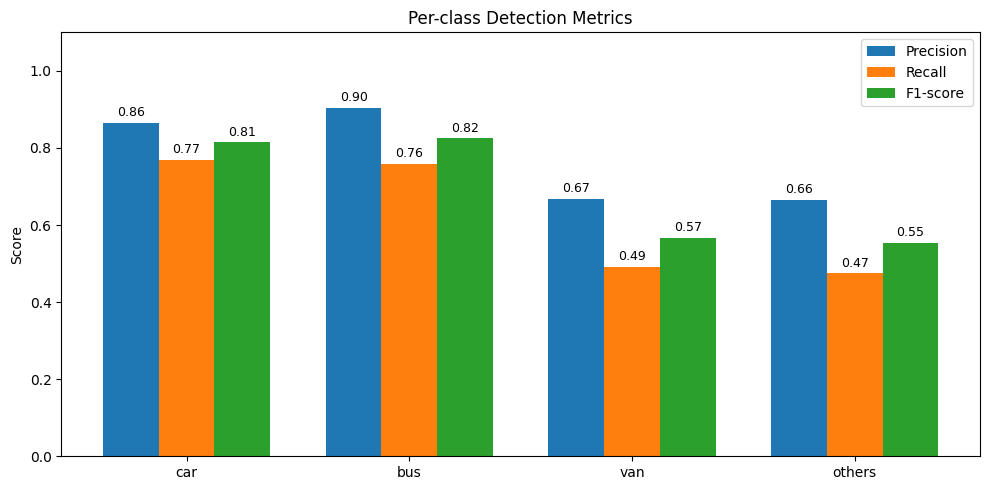

In [42]:
evaluate_predictions(
    pred_dir="runs/detect/final_best_model_pred/labels",
    gt_dir="labels/test",
    xml_dir="Test-Annotations",
    image_size=(960, 540)
)